### Import OpenVisus and add one utility function to load images from disk or network

In [1]:
import sys,os,numpy,cv2
from   skimage.metrics import structural_similarity as ssim
from   PIL import Image,ImageChops
from   urllib.request import urlopen
import matplotlib.pyplot as plt
import tempfile

%matplotlib inline

# if you have OpenVisus binary dir somewhere not in site-packages
sys.path.append(r"D:\projects\OpenVisus\build\RelWithDebInfo")
from OpenVisus import *

# utility to load images
def LoadImage(filename):
	if filename.startswith("http"):
		filename=urlopen(filename) 
		size=int(filename.info()['Content-Length'])
		return [numpy.asarray(Image.open(filename)),size]
	else:
		size=os.stat(filename).st_size
		return [numpy.asarray(Image.open(filename)),size]

print("OpenVisus imported and utils added")

OpenVisus imported and utils added


### Open one source image which will be compared to IDX compressed one

C:\Users\scrgiorgio\AppData\Roaming\Python\Python37\site-packages\PIL\Image.py:2735: DecompressionBombWarning: Image size (100000000 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  DecompressionBombWarning,


Src image loaded SrcSize 79 MB shape (10000, 10000, 3) dtype uint8


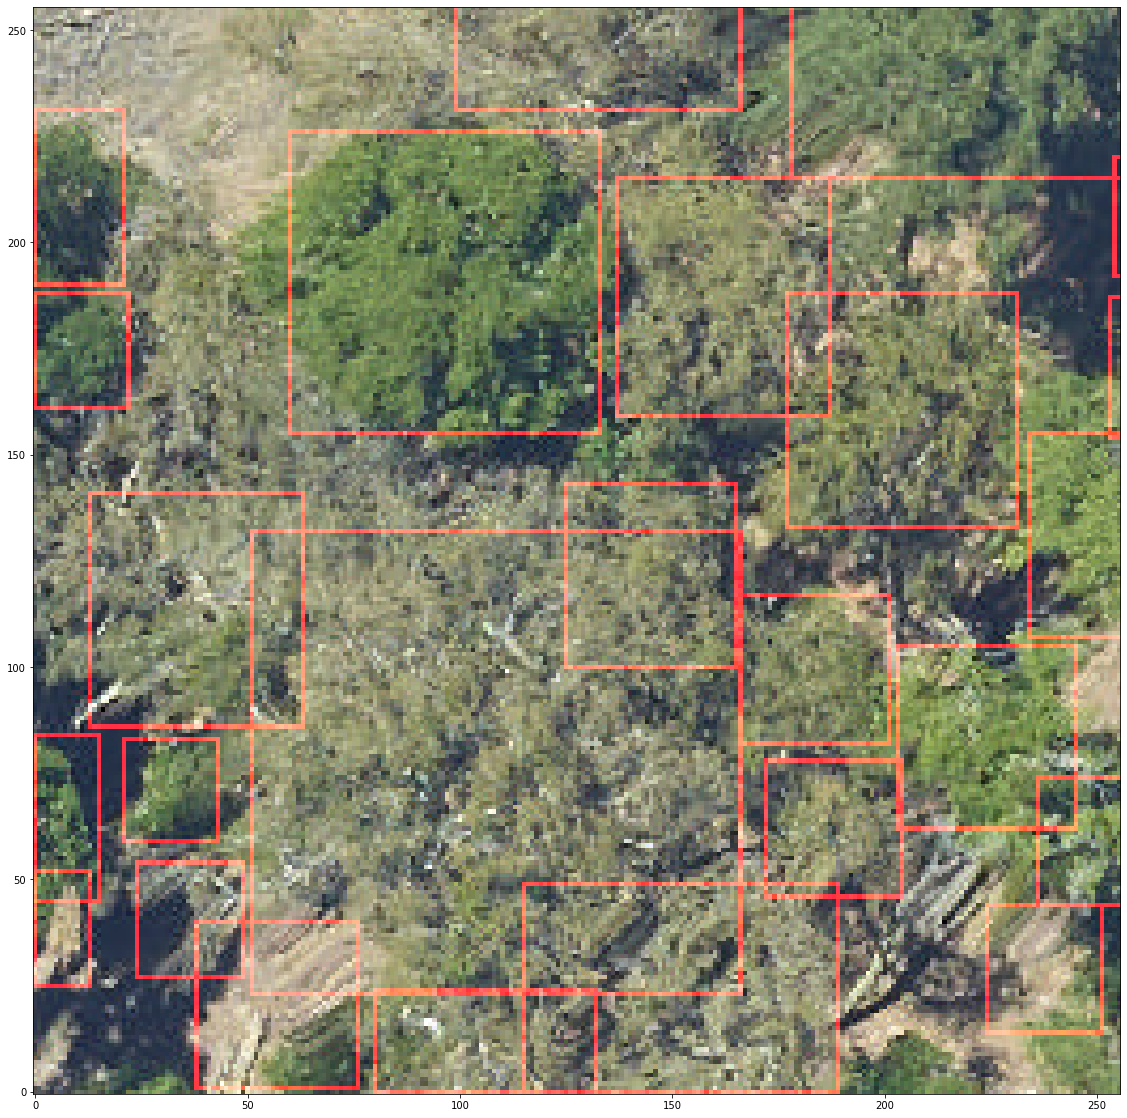

In [2]:
def ShowImage(data):
    fig =  plt.figure(figsize = (70,20))
    ax = fig.add_subplot(1,1,1)
    ax.imshow(data, origin='lower')
    plt.show()
    
test="neon"

if test=="neon":
    # show red lines (annotatoions from 'rasterize' file)
    url="https://github.com/sci-visus/OpenVisus/releases/download/test__compression/"
    filename="2019_OSBS_5_402000_3284000_image.tif"
    #filename="2019_OSBS_5_403000_3284000_image.tif"
    src,src_size=LoadImage(url+filename)
    ras,ras_size=LoadImage(url+filename.replace(".tif","_rasterized.tif"))
    src=numpy.copy(src)
    src[:,:,0][ras>0]=255
    preview_size=256
    src_preview=src[0:preview_size,0:preview_size,:]
    
if test=="david":
    src,src_size=LoadImage("https://is4-ssl.mzstatic.com/image/thumb/Purple3/v4/ed/b1/08/edb108f6-aa0c-e3ad-97e5-00a15329b5eb/mzl.oqyivrxl.png/643x0w.jpg")
    src=numpy.flip(src,axis=0)
    src=numpy.ascontiguousarray(src)
    src_preview=src
    
if test=="hdr":
    src,src_size=LoadImage("https://color.viewsonic.com/asset-files/images/journal/High-Dynamic-Range.jpg")
    src=numpy.flip(src,axis=0)
    src=numpy.ascontiguousarray(src)
    src_preview=src    
    
    
print("Src image loaded","SrcSize",int(src_size/(1024*1024)),"MB","shape",src.shape,"dtype",src.dtype)
ShowImage(src_preview)

### Add a function to test IDX dataset  `compression` 

In [3]:
# Here I'm assuming I have RGB data uint8 (i.ei bitsperblock=15 corresponds to 2^15*3/1024=96KB)
bitsperblock=15

# one file per dataset
blocksperfile=-1    

def TestCompression(compression,data=None, filename=next(tempfile._get_candidate_names()),filter=None):
    
    filename_bin=filename + ".bin"
    db=CreateIdx(
        url=filename, 
        filename_template=filename_bin, 
        dim=2,data=data, 
        bitsperblock=bitsperblock, 
        blocksperfile=-1,
        filters=[] if filter is None else [filter])
    
    print("Created db",filename)
    
    if filter is not None:
        print("Computing filter...")
        db.computeFilter(db.getDefaultField())
    
    print("Compressing dataset...")
    db.compressDataset(compression) 
    idx_size=os.stat(filename_bin).st_size 
    print("Size ratio idx:src {:.2f}:1".format(idx_size/src_size)) 
    
    # read a little preview
    idx_preview=PyDataset(filename).read(x=[0,src_preview.shape[1]],y=[0,src_preview.shape[0]])
    if filter is not None:
        idx_preview=idx_preview[:,:,0:3] # last channels are just coefficients
    ShowImage(idx_preview)
    
    # show diff1 using image difference
    diff1=numpy.array(ImageChops.difference(Image.fromarray(src_preview), Image.fromarray(idx_preview)))
    ShowImage(diff1)

    # show diff2 using structure similarity
    __score__,diff2 = ssim(src_preview, idx_preview, full=True, multichannel=True)
    diff2=(diff2+1.0)*0.5
    diff2=(diff2*255.0).astype(numpy.uint8)
    ShowImage(diff2)
    
    # remove all temporary files
    os.remove(filename)
    os.remove(filename_bin)

### Loss-less zip compression: idx binary file is too big, obviously no artifacts

Created db 69bp6z79
Compressing dataset...
Size ratio idx:src 3.22:1


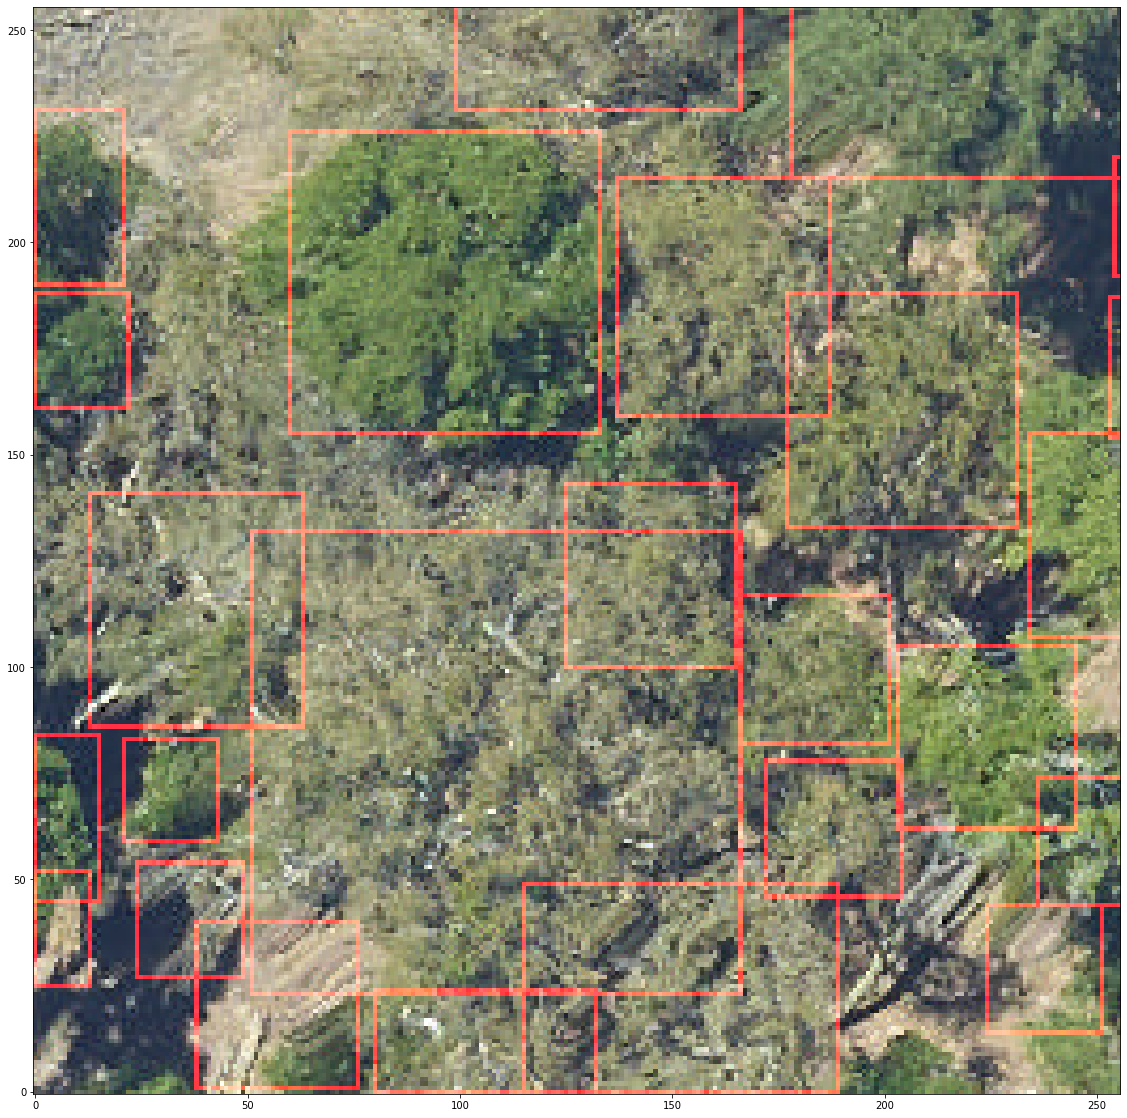

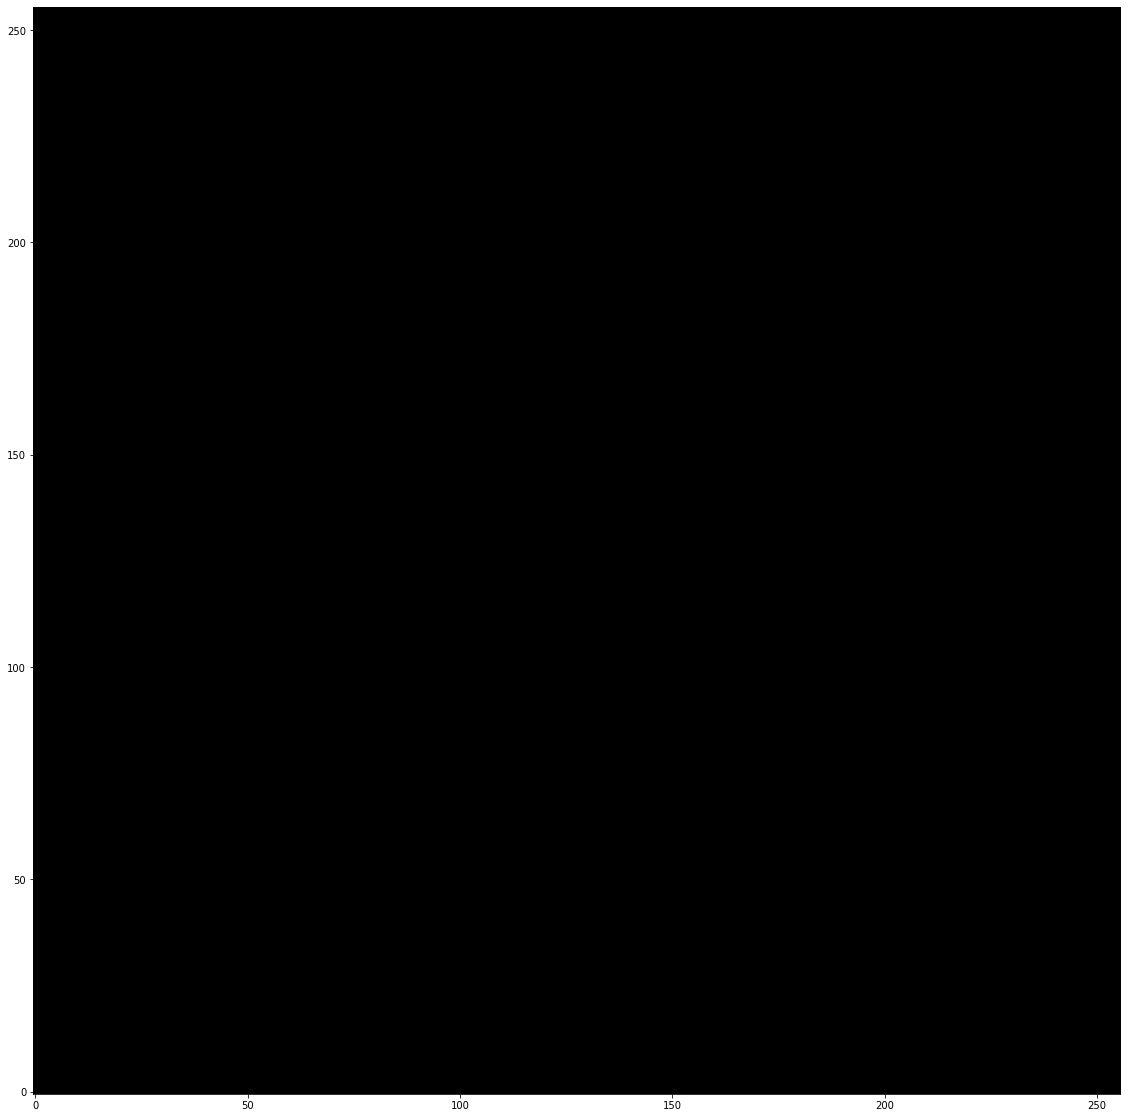

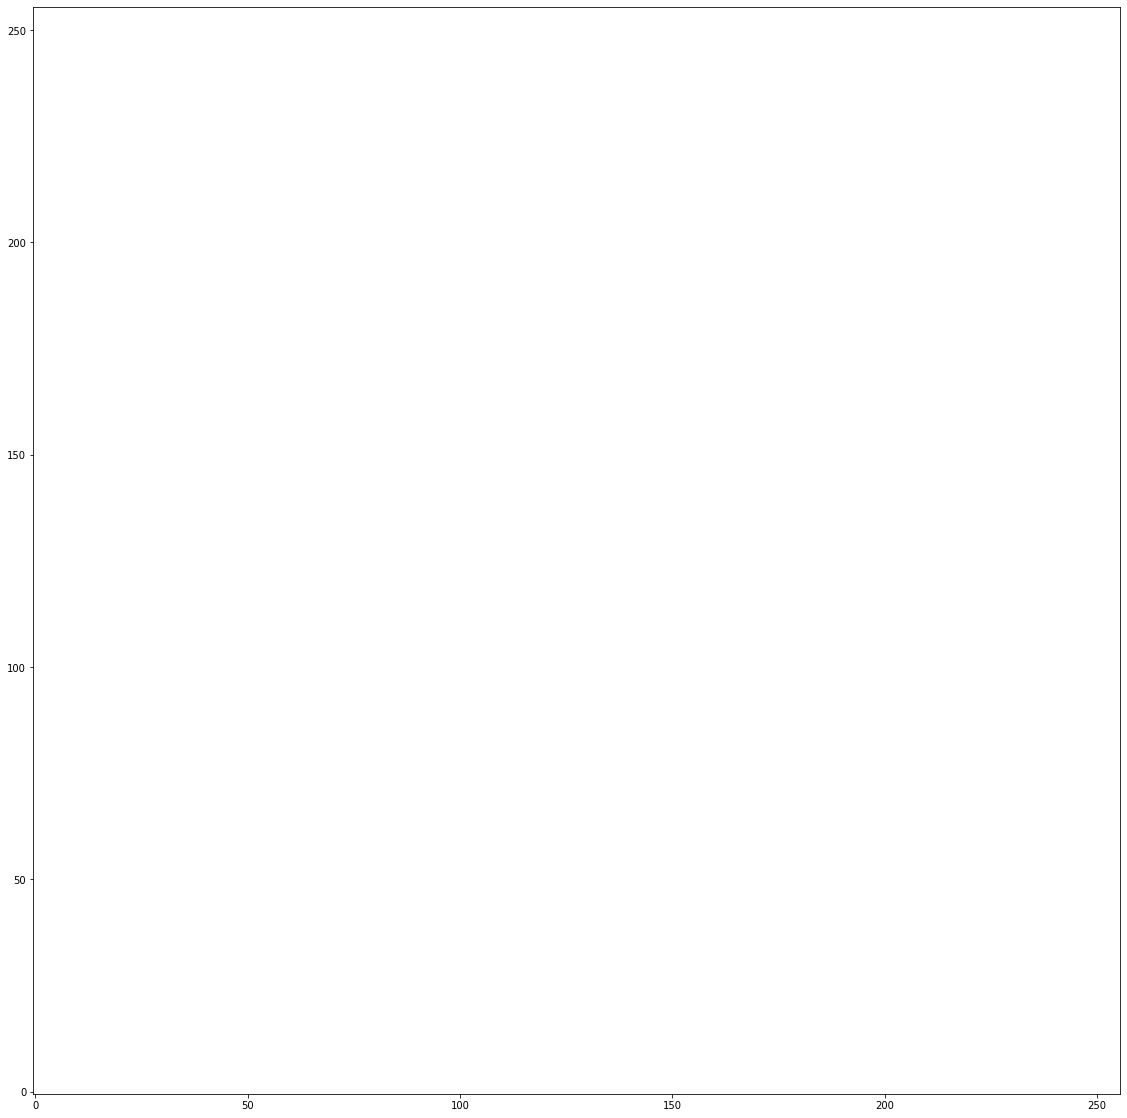

In [4]:
TestCompression("zip",data=src)

### JPEG good 420, unusable, tons of artifacts everywere (good compression ratio). Unusable

Created db 69bp6z79
Compressing dataset...
Size ratio idx:src 0.45:1


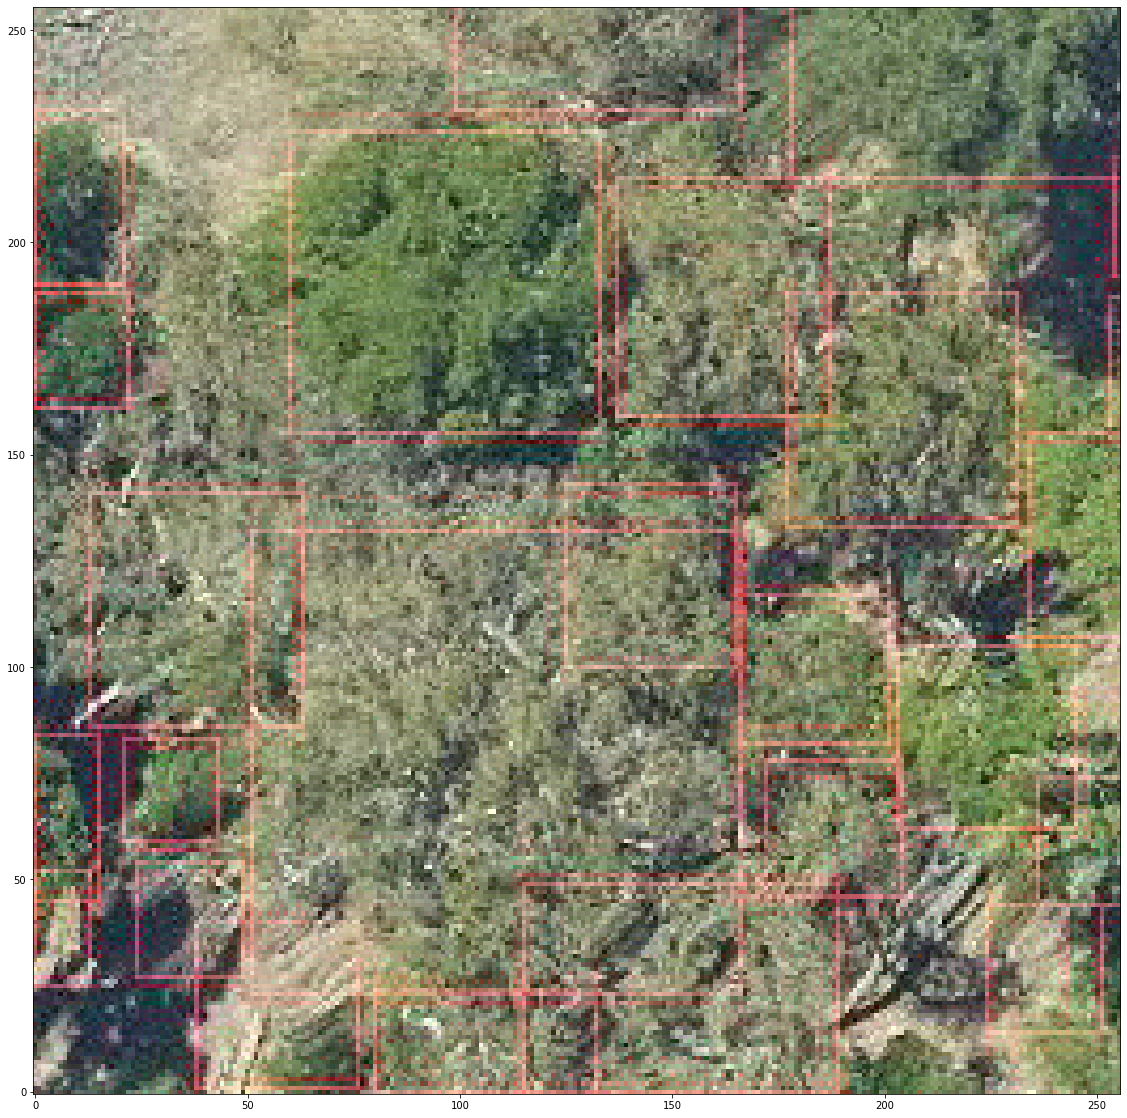

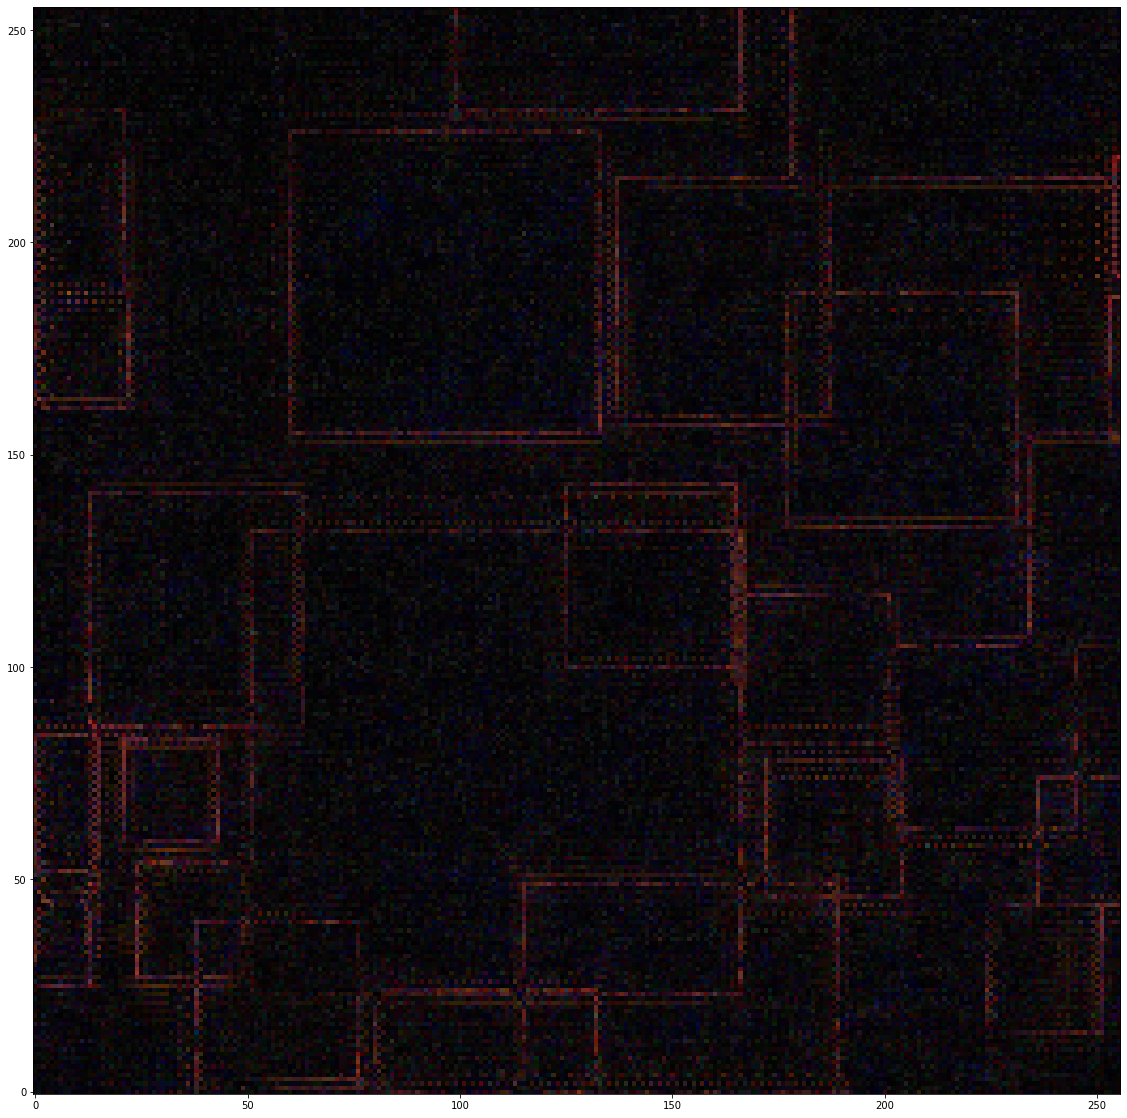

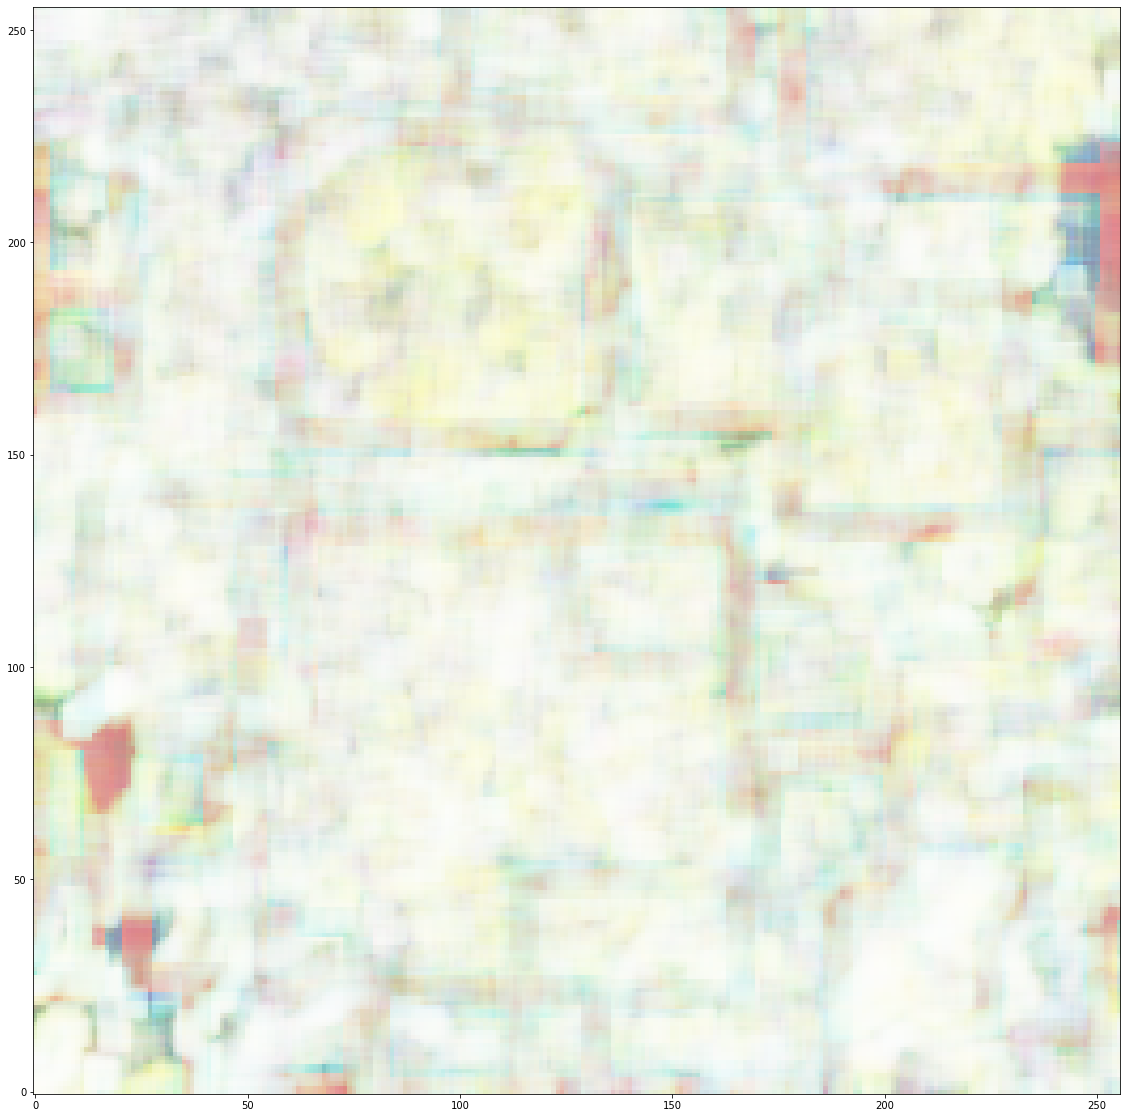

In [5]:
TestCompression("jpg-JPEG_QUALITYGOOD-JPEG_SUBSAMPLING_420-JPEG_OPTIMIZE",data=src)

### jpeg good 444 (Steve preferite). Random noise spread everywhere but low frequency. Kind of usable?

Created db 69bp6z79
Compressing dataset...
Size ratio idx:src 0.56:1


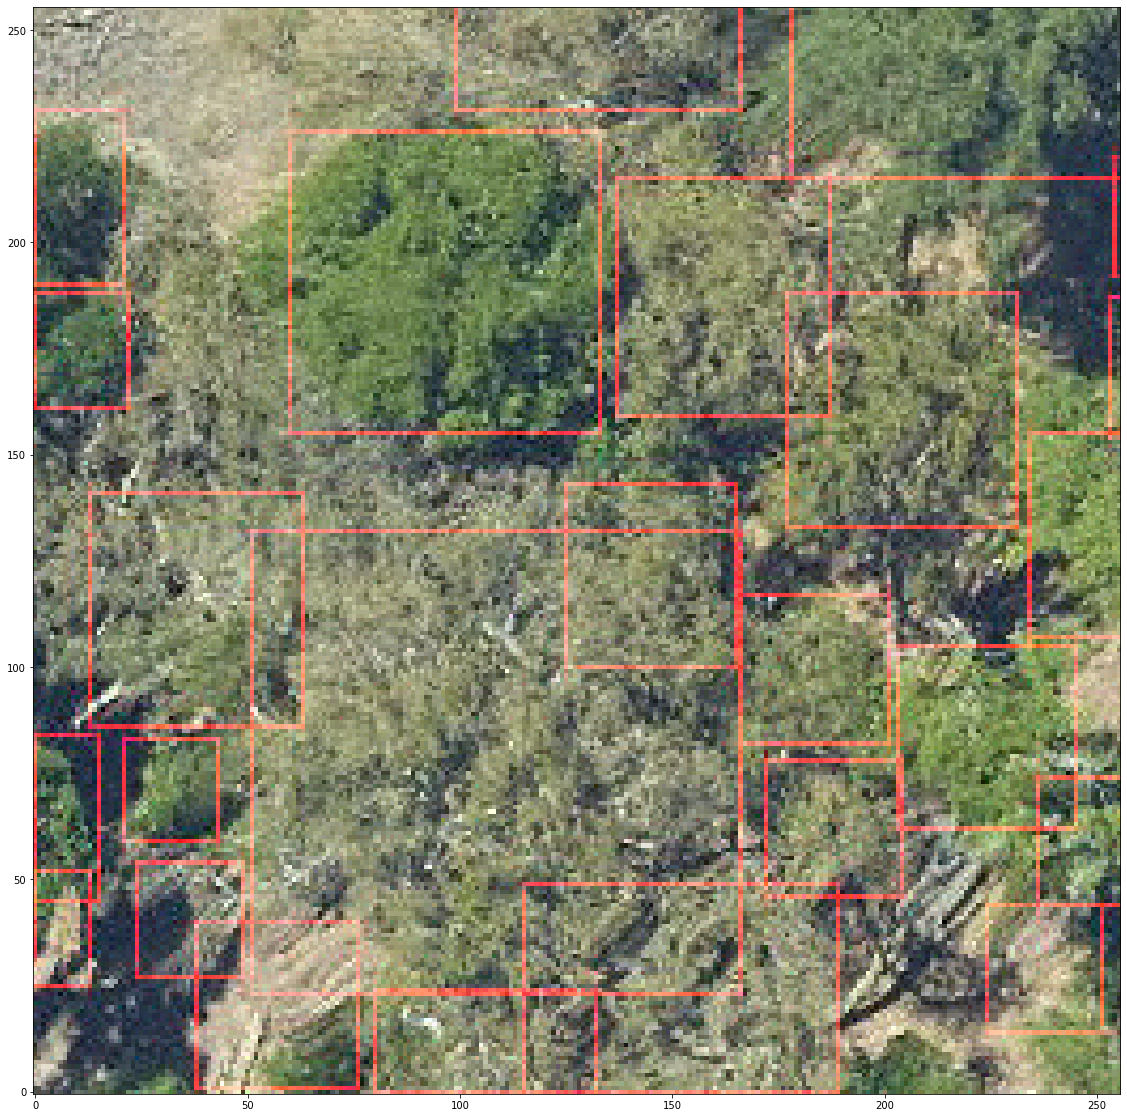

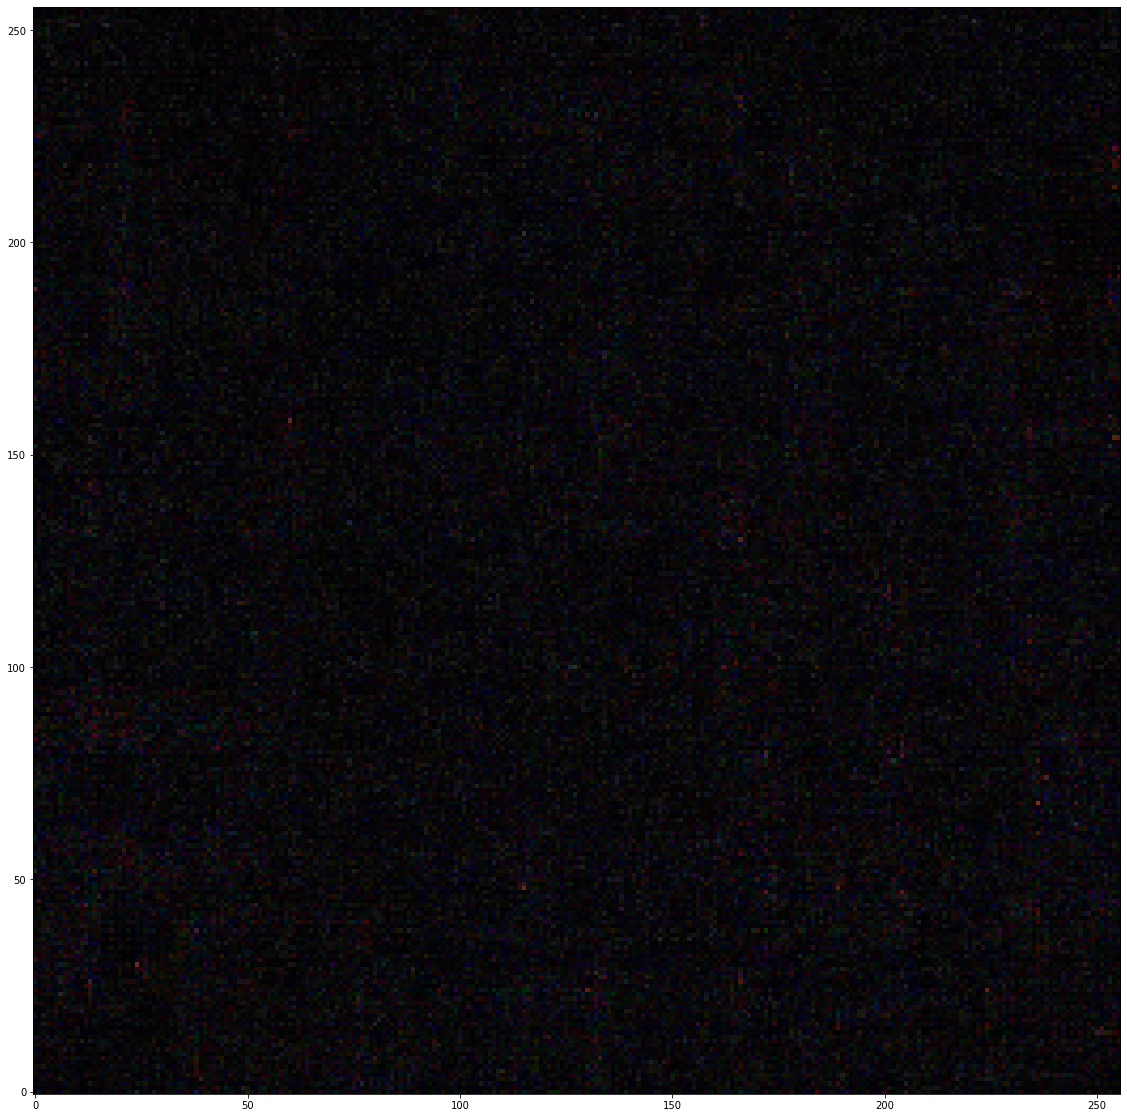

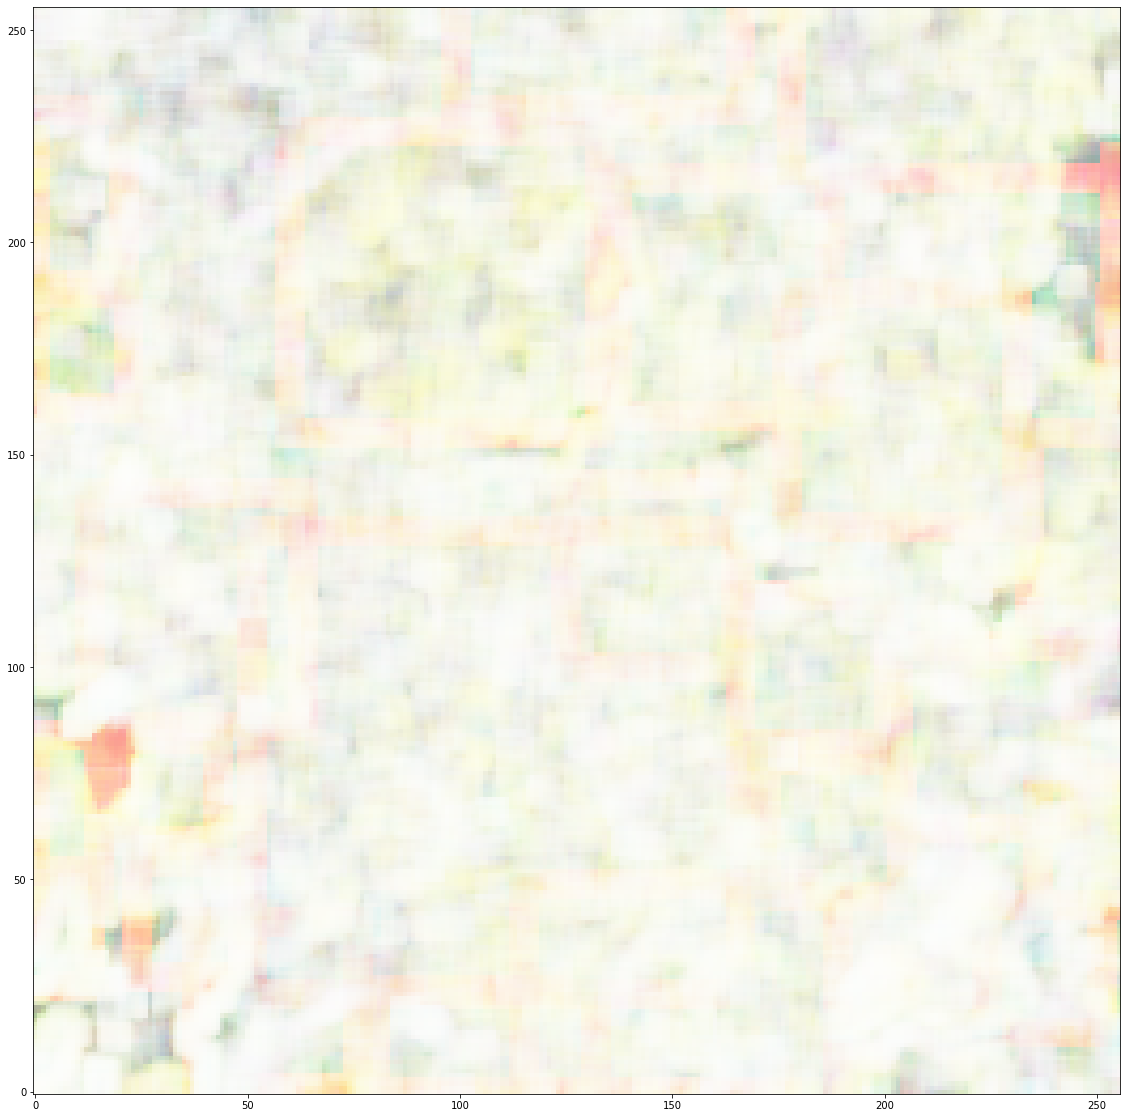

In [6]:
TestCompression("jpg-JPEG_QUALITYGOOD-JPEG_SUBSAMPLING_444-JPEG_OPTIMIZE",data=src)

### jpeg superb 420. Unusable tons of artifacts.

Created db 69bp6z79
Compressing dataset...
Size ratio idx:src 1.38:1


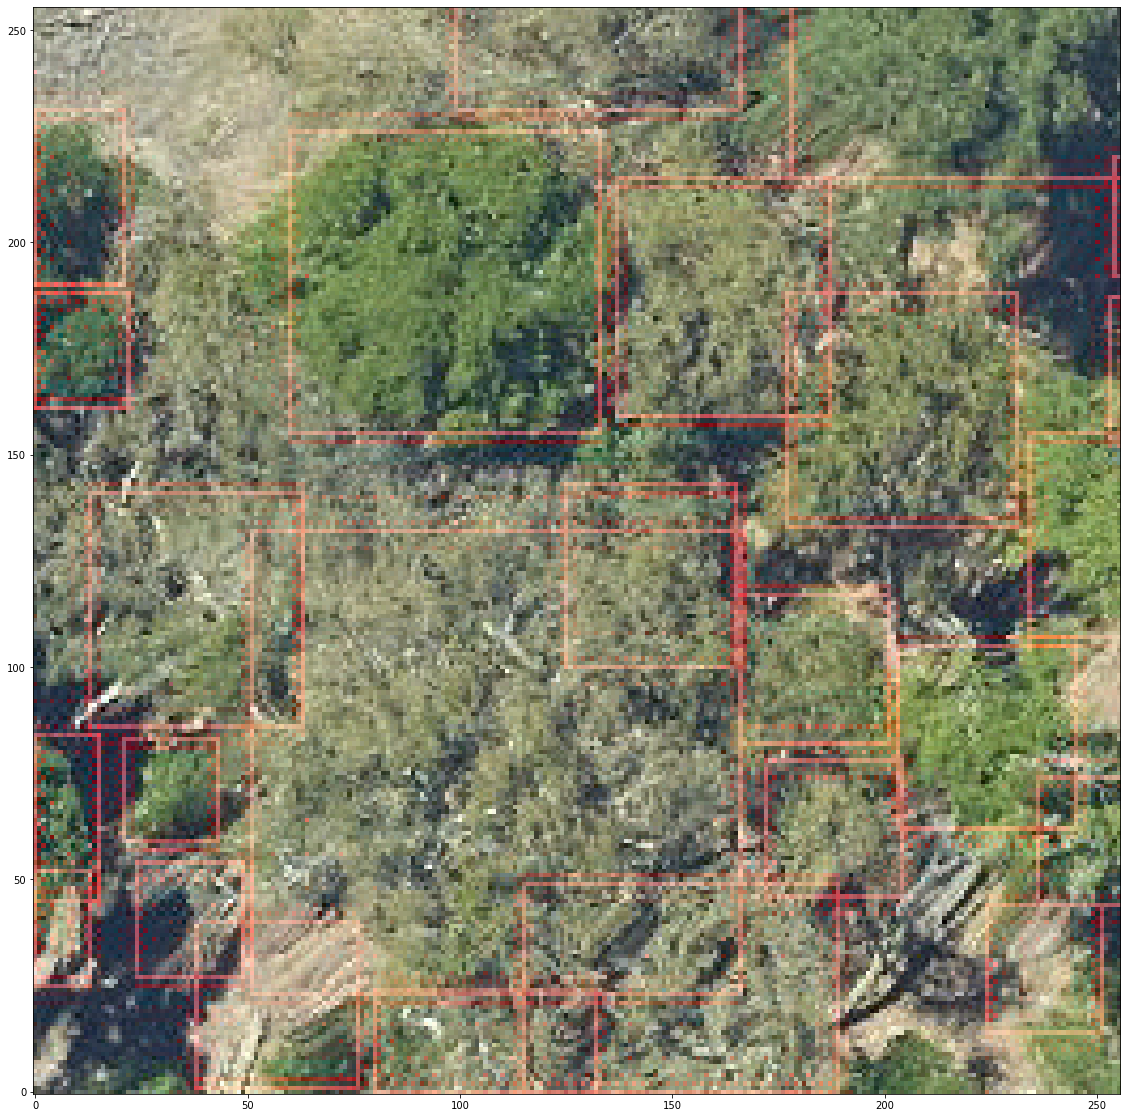

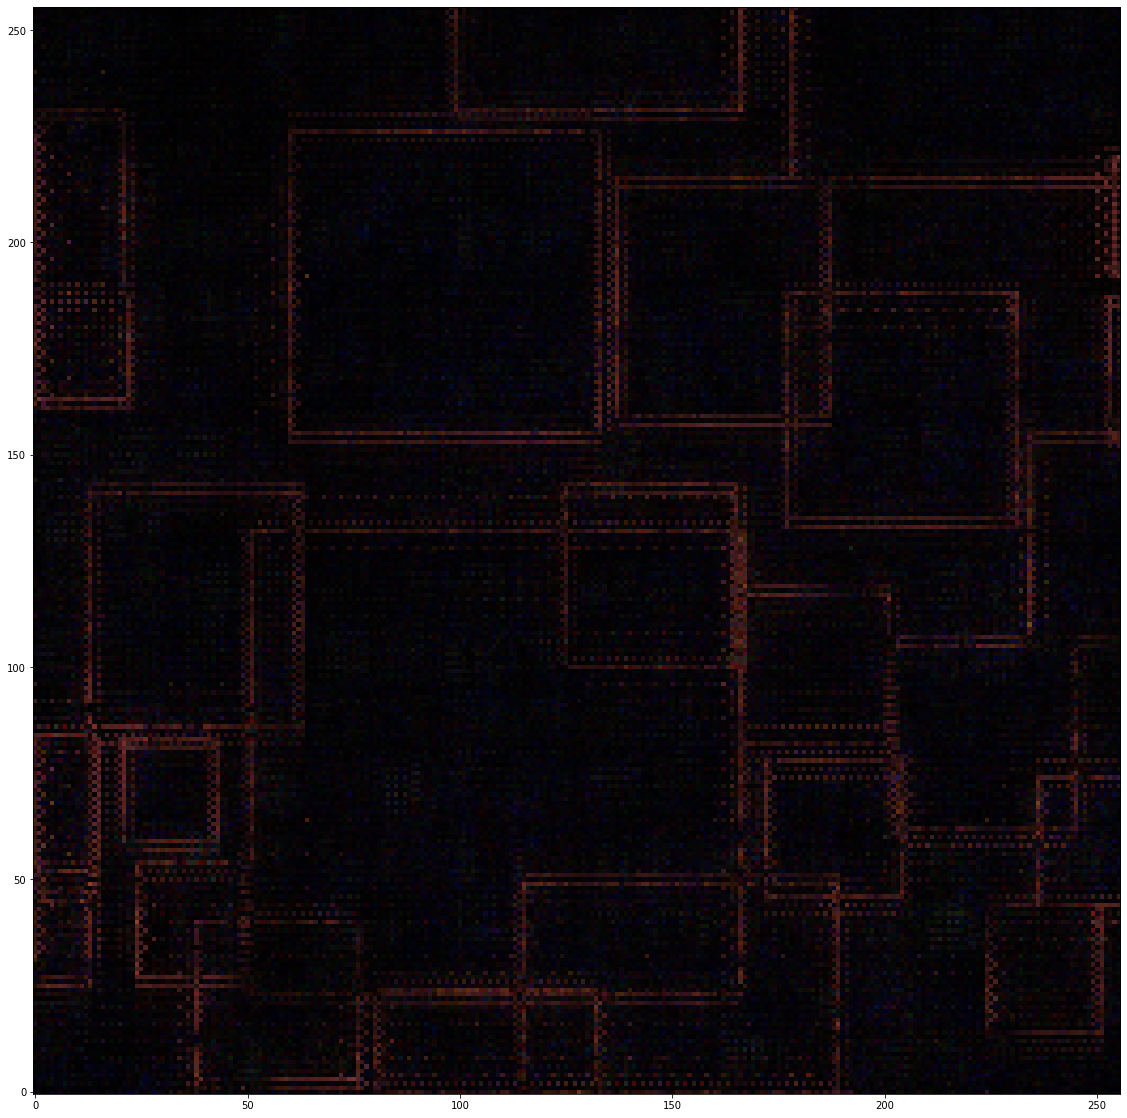

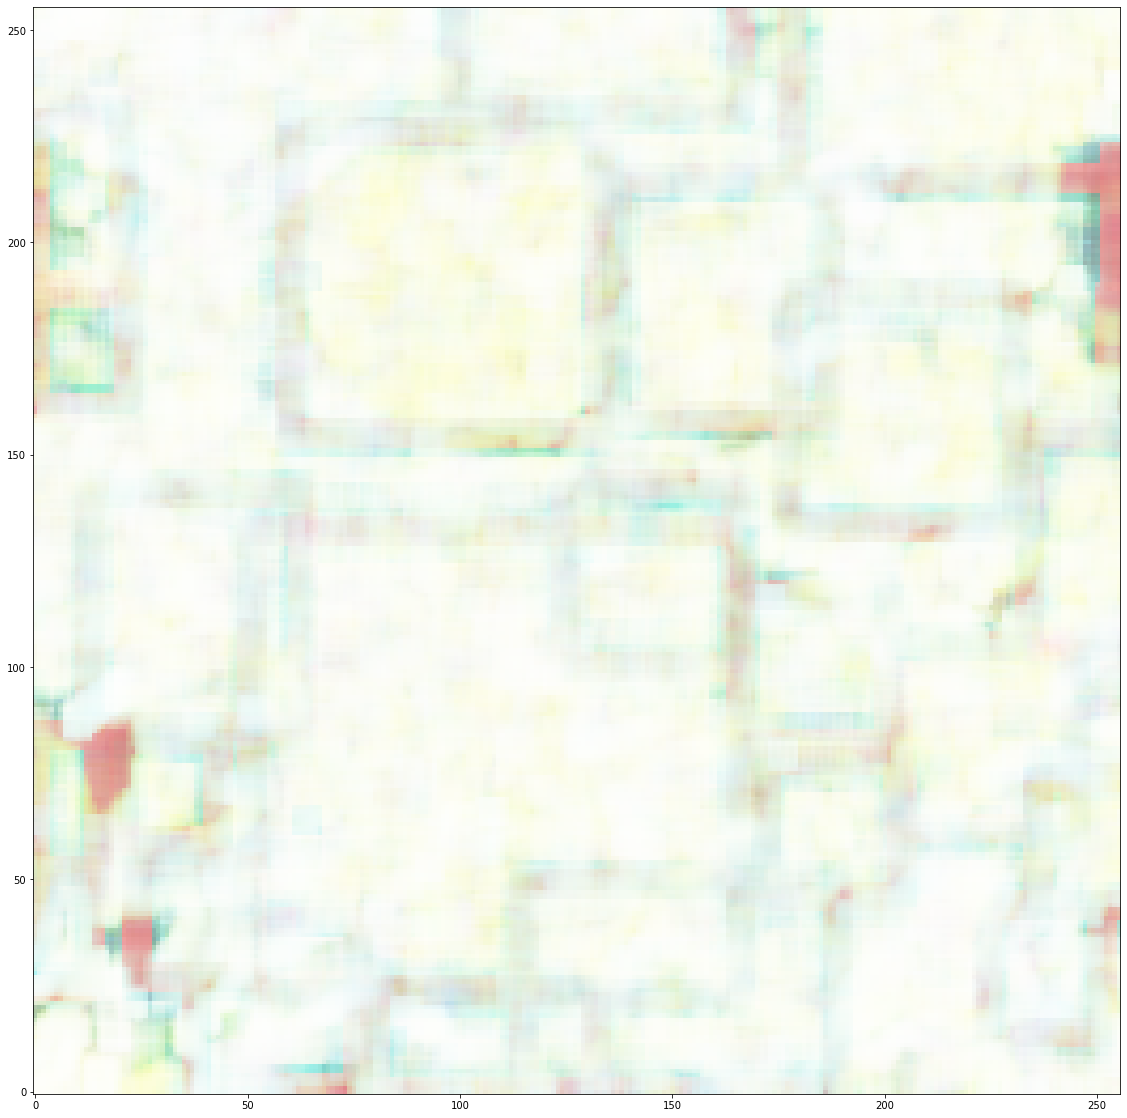

In [7]:
TestCompression("jpg-JPEG_QUALITYSUPERB-JPEG_SUBSAMPLING_420-JPEG_OPTIMIZE",data=src)

### jpeg superb. Good quality but file too big.

Created db 69bp6z79
Compressing dataset...
Size ratio idx:src 2.45:1


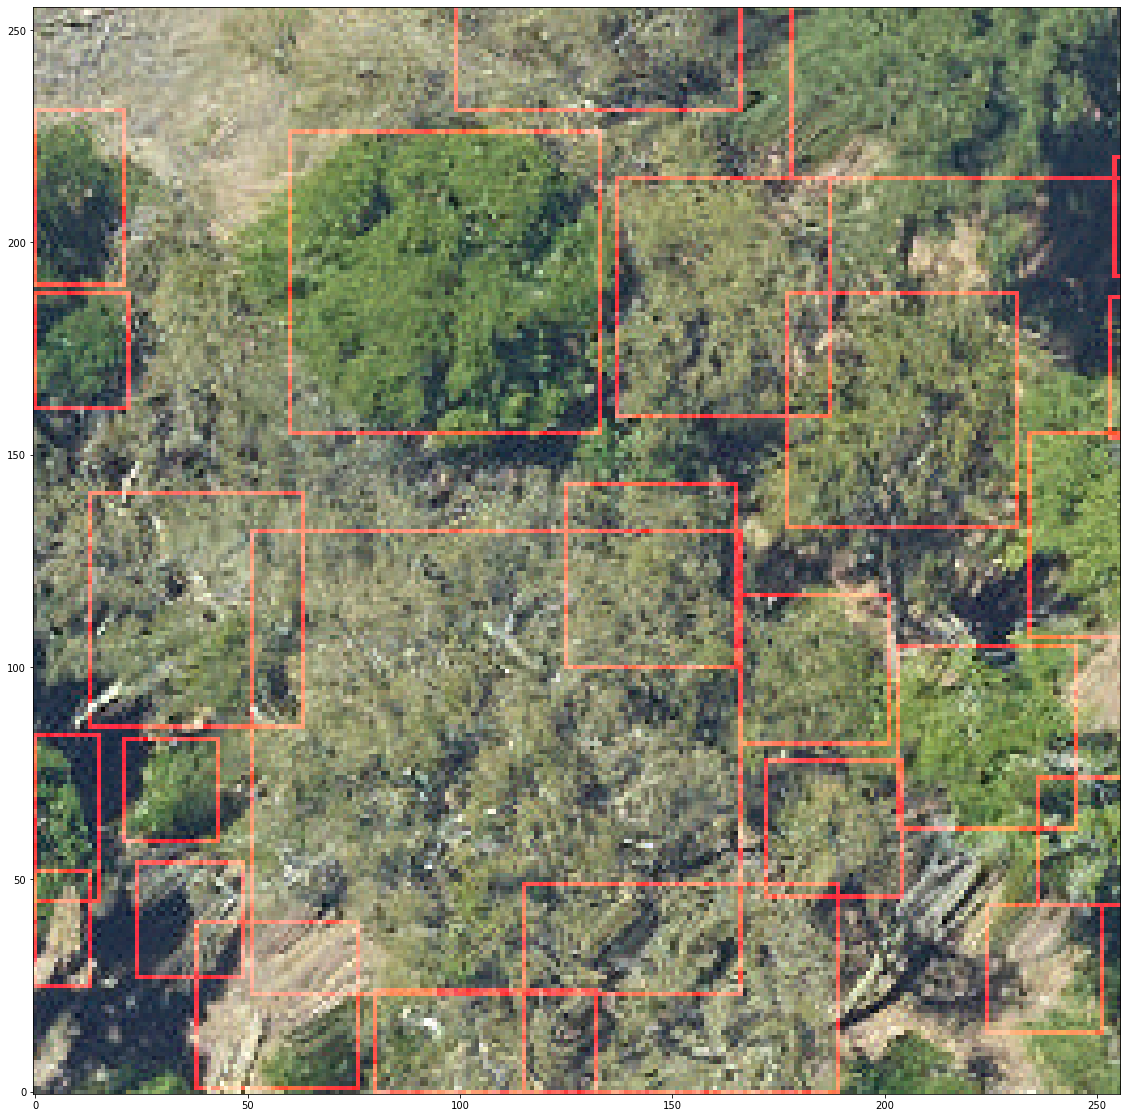

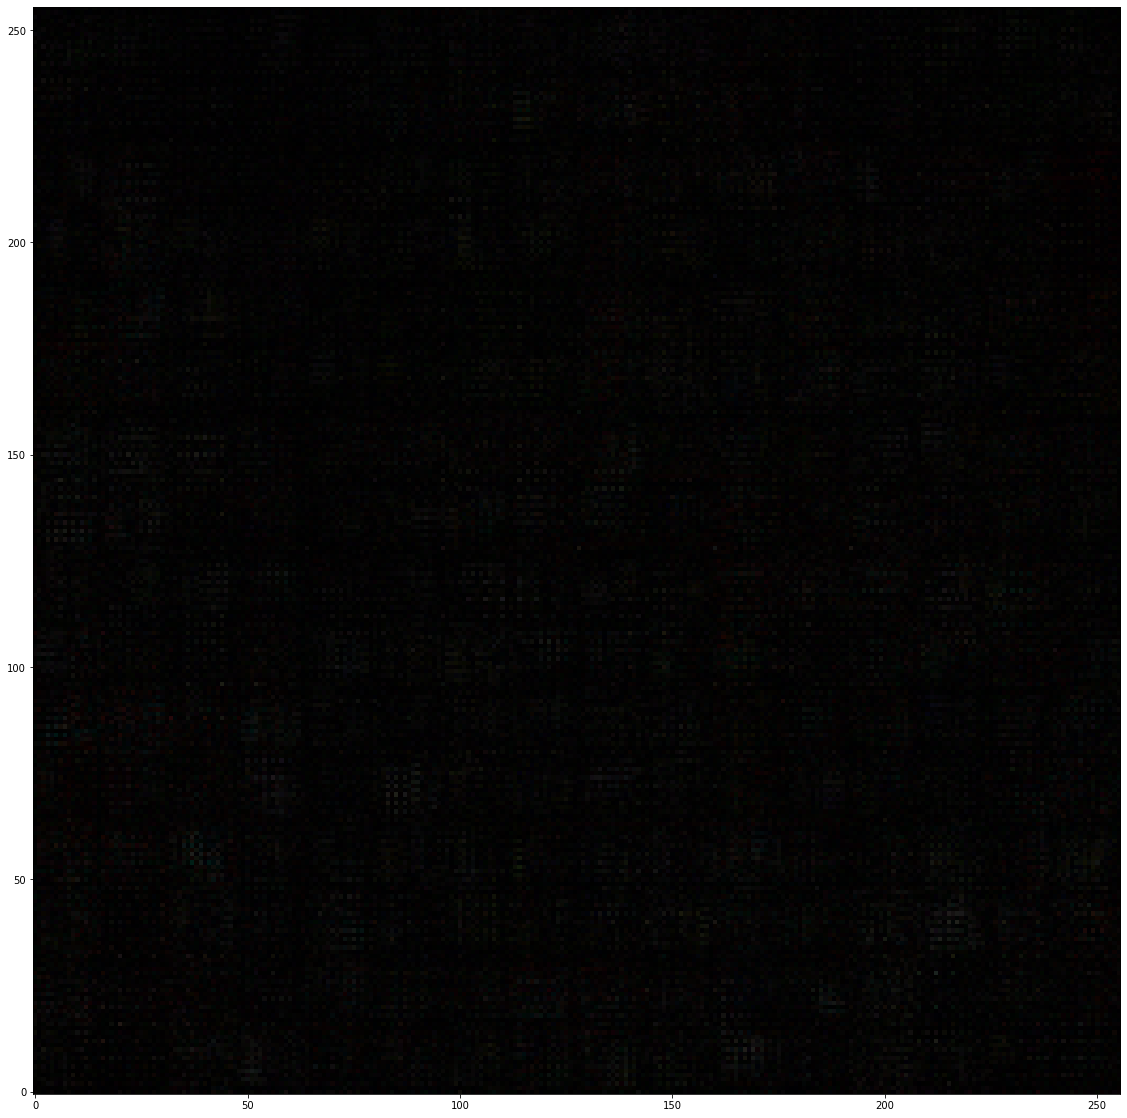

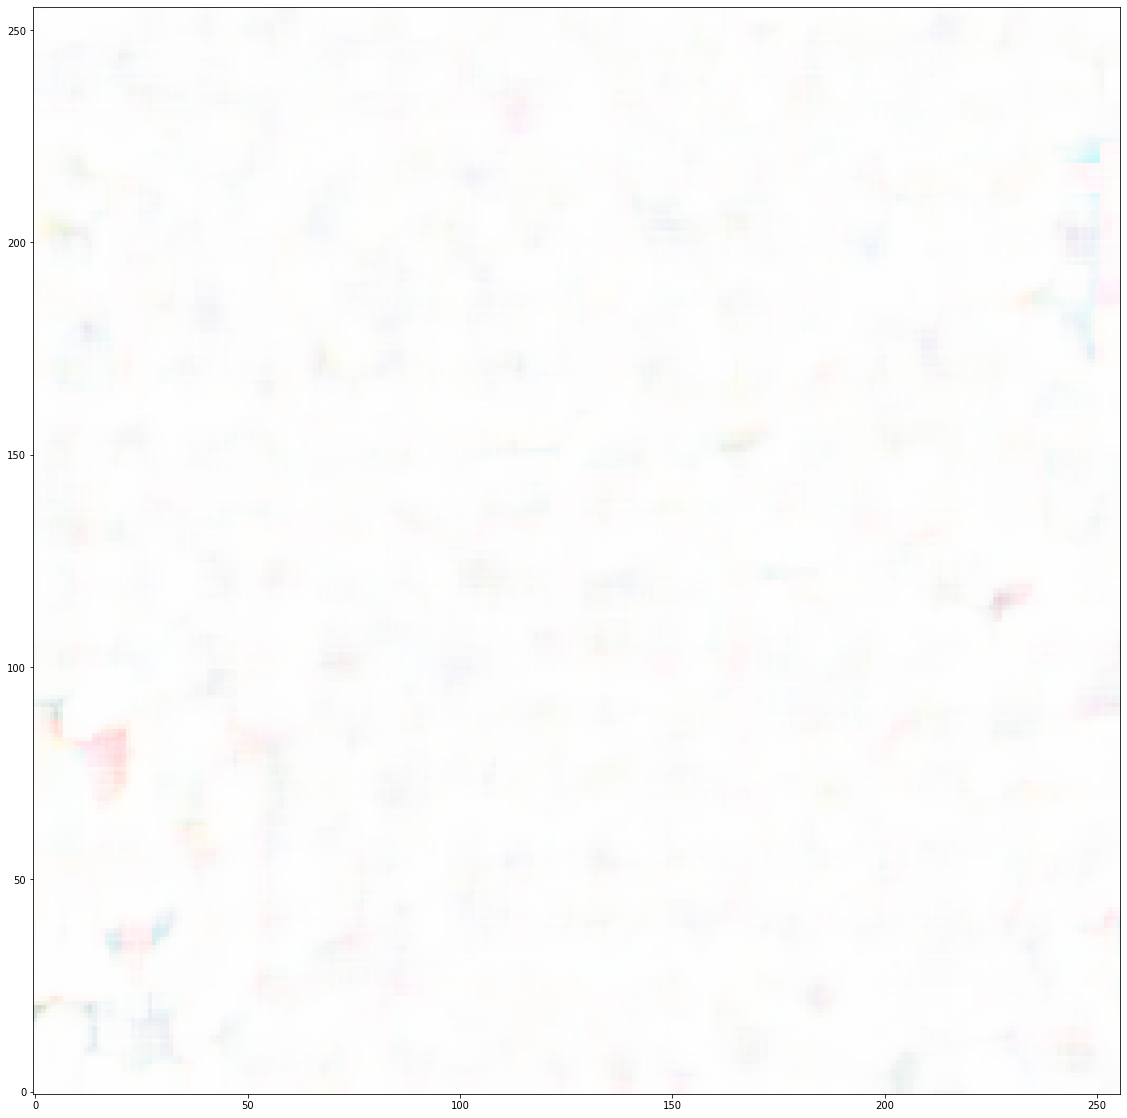

In [8]:
TestCompression("jpg-JPEG_QUALITYSUPERB-JPEG_SUBSAMPLING_444-JPEG_OPTIMIZE",data=src)

### IDX Wavelet hoping for better zip compression. But compression is still bad.

Created db 69bp6z79
Computing filter...
Compressing dataset...
Size ratio idx:src 3.19:1


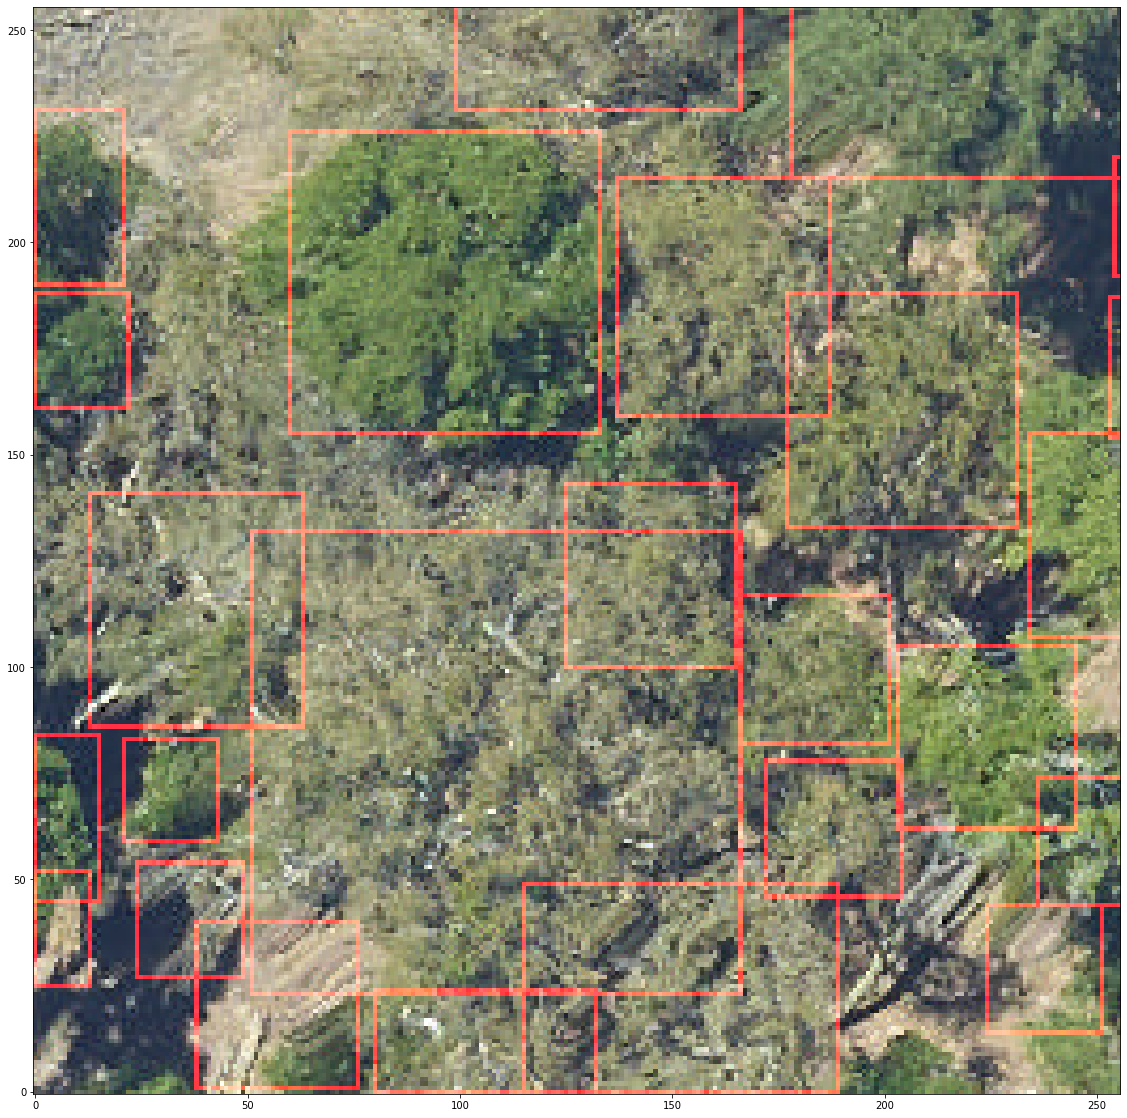

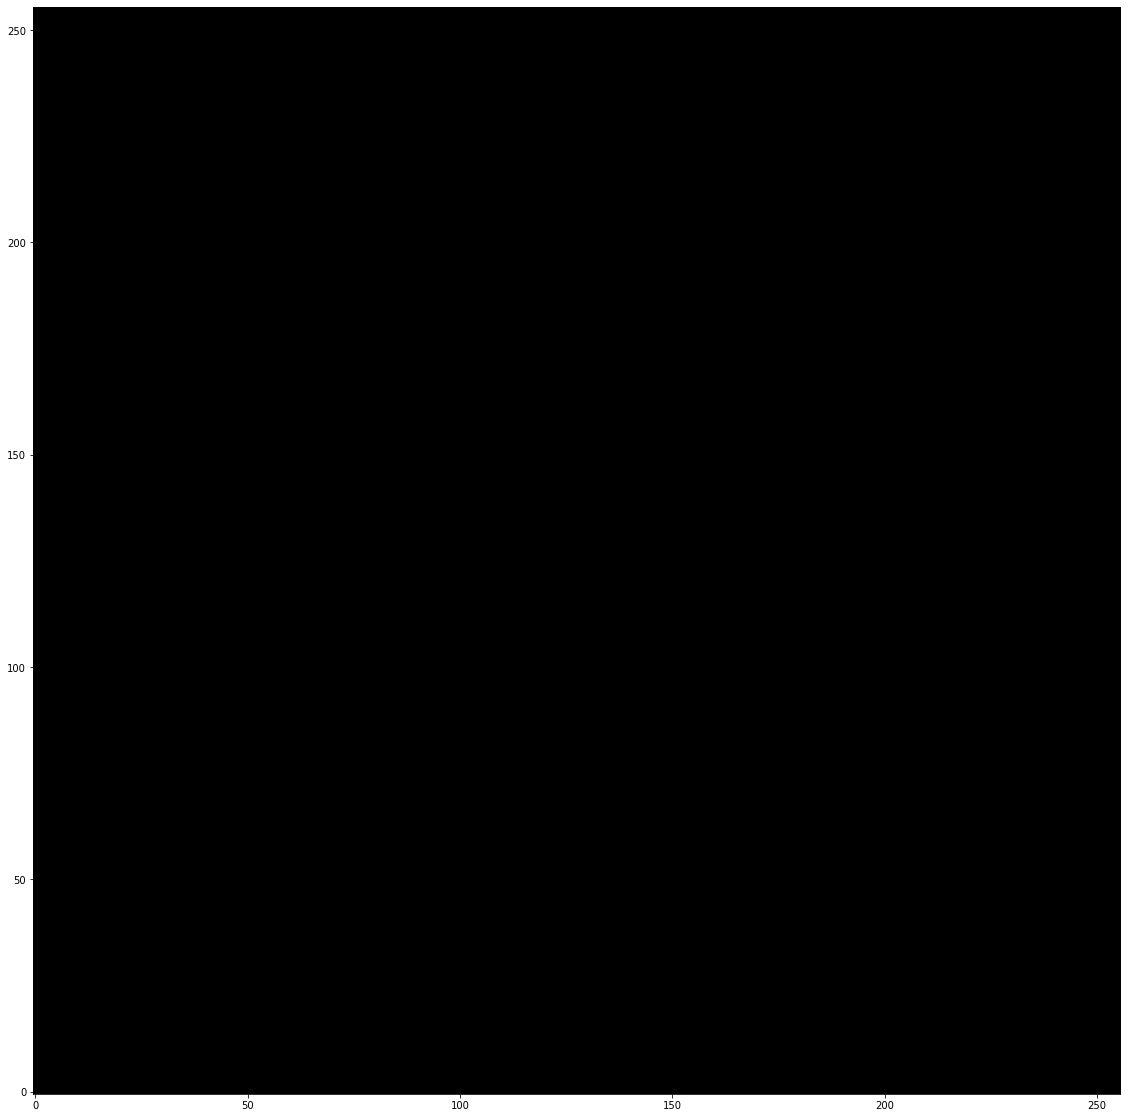

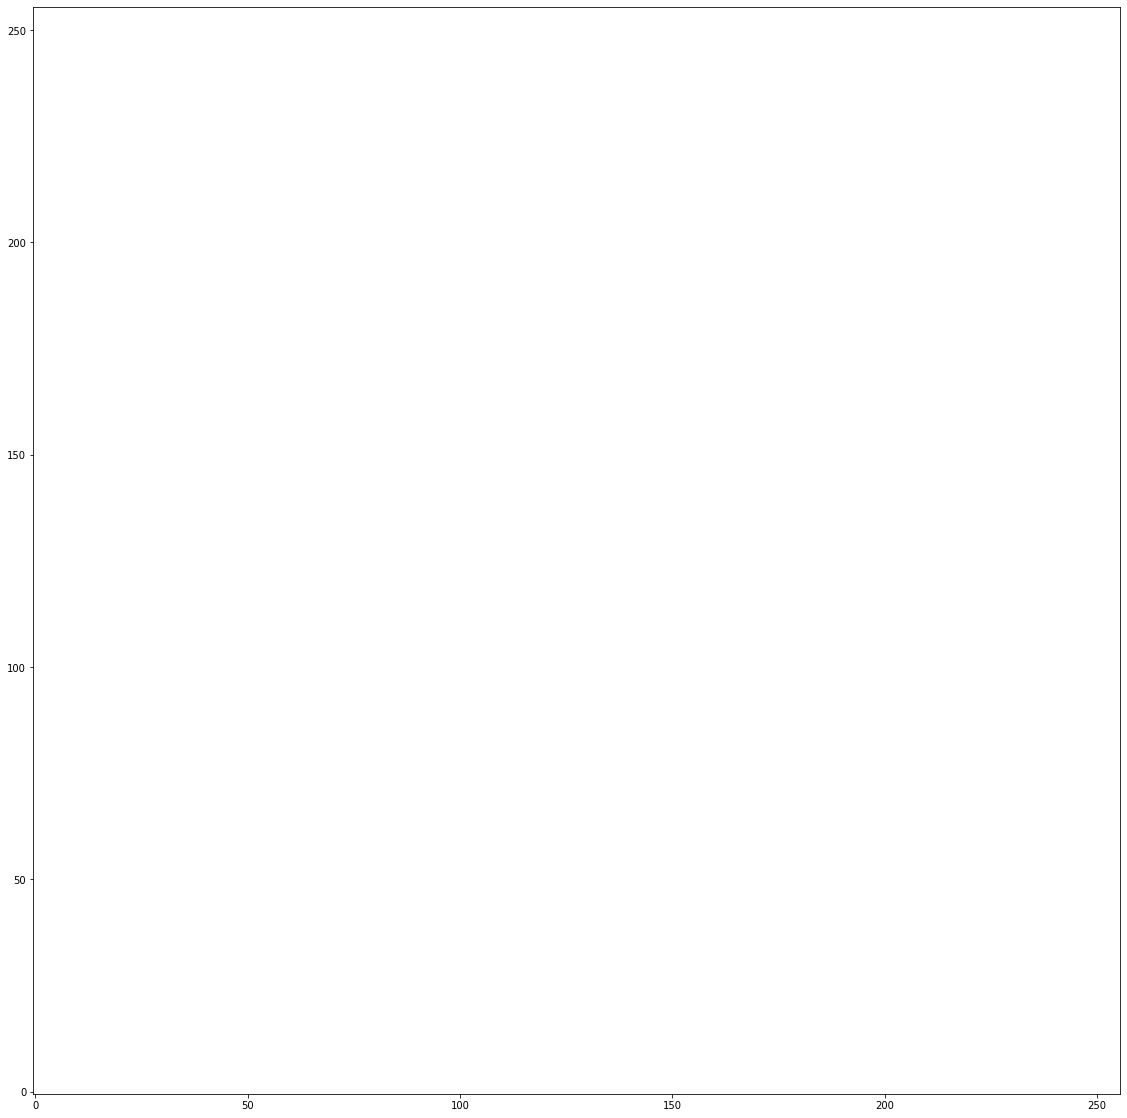

In [9]:
# i need an extra channel for wavelets coefficients
H,W,N=src.shape
Assert(N==3 and src.dtype==numpy.uint8)
rgbw=numpy.zeros((H,W,4),dtype=numpy.uint8)
rgbw[:,:,0:3]=src

TestCompression("zip",data=rgbw,filter="wavelet")

### Conclusion. Can we use JPEG at different ratio for different levels dependent on the "vicinity" of pixels?

Let's assume zip has compression ratio of 3.22.
Let's assume we use JPEG-good-444 which has compression ratio of 0.56.

Let's say we apply 'good' jpeg NNN to last 2 levels (2 pixel distance).  
75% of the dataset (last 2 levels) will be compressed JPEG and all other levels in zip

Final size will be (TO DOUBLE CHECK)

3.22*0.25*1.0 + 0.56*0.75*1.0=1.225

if we apply JPEG to last 3 levels (4 pixel distance)

3.22*0.125*1.0 + 0.56*0.875*1.0=0.89